In [19]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from typing import Tuple

In [46]:
class ActuatorDataset(Dataset):
    def __init__(self, csv_path: str,
                 history_steps: int = 3,
                 target_freq: int = 100):
        """
        Args:
            csv_path: Path to CSV file
            history_steps: Number of history steps (paper uses 3: t, t-0.01, t-0.02)
        """
        self.raw_df = pd.read_csv(csv_path)
        self.target_dt = 1 / target_freq

        self.measured_dts = np.diff(self.raw_df["time"].values)
        self.raw_dt= np.mean(self.measured_dts)
        current_freq = 1 / self.raw_dt
        downsample_factor = int( current_freq/ target_freq)

        # downsample the data
        self.df = self.raw_df[::downsample_factor].reset_index(drop=True)
        measured_dts = np.diff(self.df["time"].values)
        mean_dt = np.mean(measured_dts)
        print(f"Mean dt: {np.mean(mean_dt):.4f}, Std dt: {np.std(measured_dts):.4f}")


        self.data = None  # Will hold processed DataFrame
        self.history_steps = history_steps
        self.scaler_params = {}  # Store normalization parameters
        self.features = None
        self.targets = None
        print(self.df.head())

        # Display basic information about the dataset
        print("Dataset Info:")
        print(self.df.info())
        print("\nFirst few rows:")
        print(self.df.head())
        print("\nBasic statistics:")
        print(self.df.describe())

        # Calculate and display timestep statistics
        dt = np.diff(self.df['time'])
        print("\nTimestep statistics:")
        print(f"Mean dt: {dt.mean():.6f}s")
        print(f"Std dt: {dt.std():.6f}s")
        print(f"Min dt: {dt.min():.6f}s")
        print(f"Max dt: {dt.max():.6f}s")
    def get_raw_data(self) -> pd.DataFrame:
        return self.raw_df
    
    def get_raw_dt(self) -> float:
        return self.raw_dt
    def get_df(self) -> pd.DataFrame:
        return self.df
    
    def preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

        self.df["position_error"] = self.df["target_position"] - self.df["position"]
        time = []
        features = []
        targets = []

        for i in range(len(self.df) - self.history_steps + 1):
            window = self.df.iloc[i:i + self.history_steps]
            # Check if window is valid
            time_diffs = np.diff(window["time"].values)
            
            if np.any(abs(time_diffs - self.target_dt) > 0.002) :
                continue
            # extract features and targets
            pos_errors = window["position_error"].values
            velocities = window["velocity"].values
            feature = np.concatenate([pos_errors, velocities])
            target = window["torque"].values[-1]
            features.append(feature)
            targets.append(target)
            time.append(window["time"].values[-1])
            
        self.features = np.array(features)
        self.targets = np.array(targets) 
        time = np.array(time)
        return self.features, self.targets, time
        
        

We separate the dataset into 100hz and 500hz 100hz per the paper.' suggested frequency.
and 500hz for the measure frequency. That we used. 

In [47]:
print("100hz dataset")
dataset_100 = ActuatorDataset("../data/data_full_200125_1914.csv")
print("500hz dataset")
dataset_500 = ActuatorDataset("../data/data_full_200125_1914.csv", target_freq=500)

100hz dataset
Mean dt: 0.0100, Std dt: 0.0003
   timestep      time  target_position  position   velocity    torque  \
0         1  0.020837              0.0 -3.959290  -0.000029  0.337083   
1         6  0.045380              0.0 -3.614312  26.469427  0.338147   
2        11  0.067461              0.0 -2.670177  50.657017 -0.078556   
3        16  0.074912              0.0 -2.304582  47.665581 -0.284223   
4        21  0.081413              0.0 -2.023355  41.204433 -0.118768   

   amplitude  frequency  Unnamed: 8  
0        0.0        0.0         NaN  
1        0.0        0.0         NaN  
2        0.0        0.0         NaN  
3        0.0        0.0         NaN  
4        0.0        0.0         NaN  
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18457 entries, 0 to 18456
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestep         18457 non-null  int64  
 1   time             18457

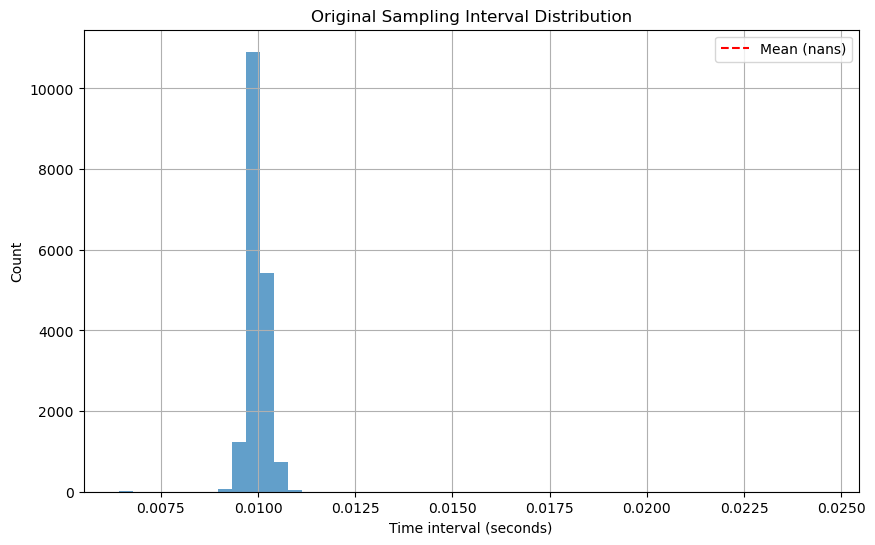

In [48]:
dt_100 = dataset_100.get_df()["time"].diff().values
plt.figure(figsize=(10, 6))
plt.hist(dt_100, bins=50, alpha=0.7)
plt.axvline(np.mean(dt_100), color='r', linestyle='--', label=f'Mean ({np.mean(dt_100):.4f}s)')
plt.title('Original Sampling Interval Distribution')
plt.xlabel('Time interval (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()

Possibly, the fact the data is not sample at a constant rate might hurts us. H 
In descriptive statistics, the interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data.[1] The IQR may also be called the midspread, middle 50%, fourth spread, or H‑spread. It is defined as the difference between the 75th and 25th percentiles of the data.[2][3][4] To calculate the IQR, the data set is divided into quartiles, or four rank-ordered even parts via linear interpolation.[1] These quartiles are denoted by Q1 (also called the lower quartile), Q2 (the median), and Q3 (also called the upper quartile). The lower quartile corresponds with the 25th percentile and the upper quartile corresponds with the 75th percentile, so IQR = Q3 −  Q1[1].
https://en.wikipedia.org/wiki/Interquartile_range

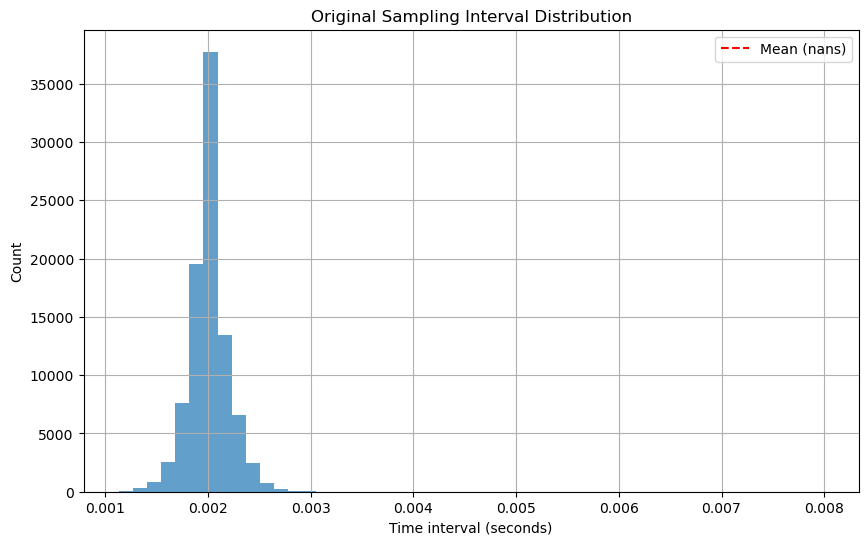

In [49]:
raw_dt = dataset_500.get_df()["time"].diff().values
plt.figure(figsize=(10, 6))
plt.hist(raw_dt, bins=50, alpha=0.7)
plt.axvline(np.mean(raw_dt), color='r', linestyle='--', label=f'Mean ({np.mean(raw_dt):.4f}s)')
plt.title('Original Sampling Interval Distribution')
plt.xlabel('Time interval (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()


Target_position Analysis:
Range: [-8.898, 8.900]
Mean ± Std: 0.026 ± 3.631
Outliers: 0 (0.00%)
Outlier range: [-9.069, 9.138]

Position Analysis:
Range: [-6.781, 7.143]
Mean ± Std: 0.008 ± 1.039
Outliers: 2030 (11.00%)
Outlier range: [-1.336, 1.252]

Velocity Analysis:
Range: [-51.296, 51.278]
Mean ± Std: 0.025 ± 15.464
Outliers: 1278 (6.92%)
Outlier range: [-29.963, 29.849]

Torque Analysis:
Range: [-0.382, 0.388]
Mean ± Std: 0.002 ± 0.276
Outliers: 0 (0.00%)
Outlier range: [-1.283, 1.284]


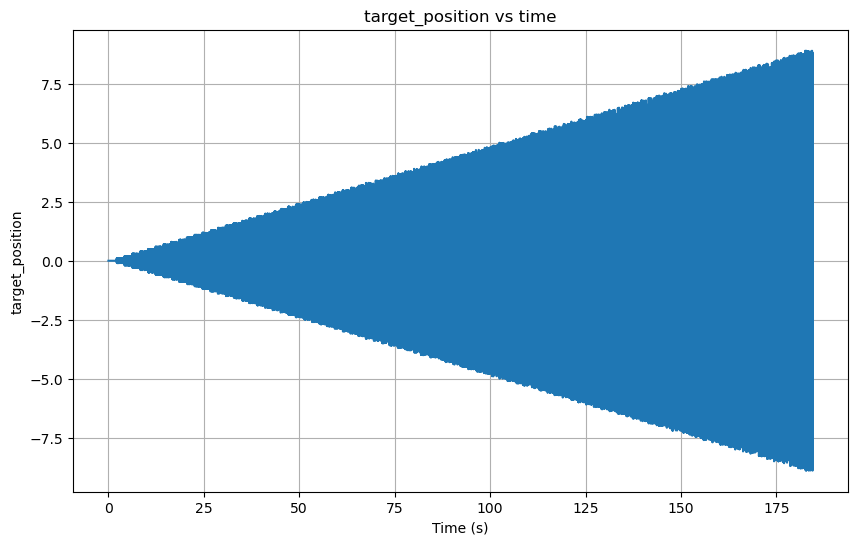

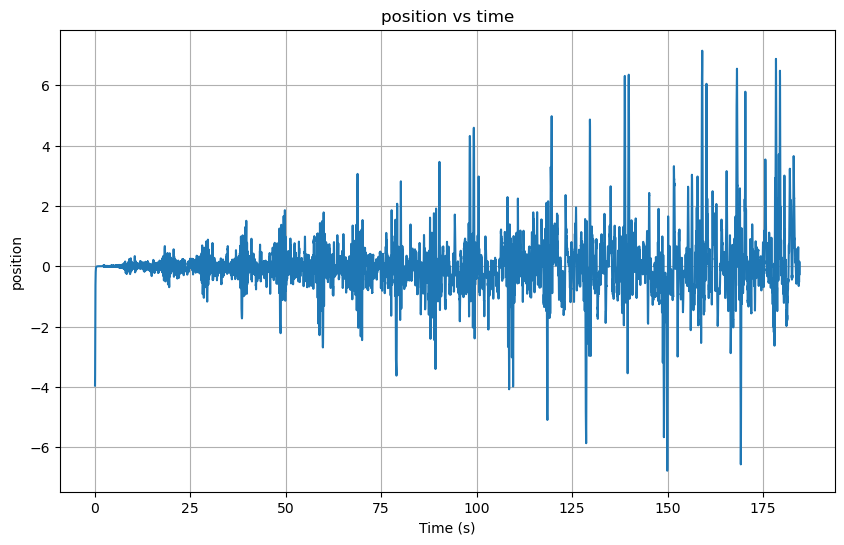

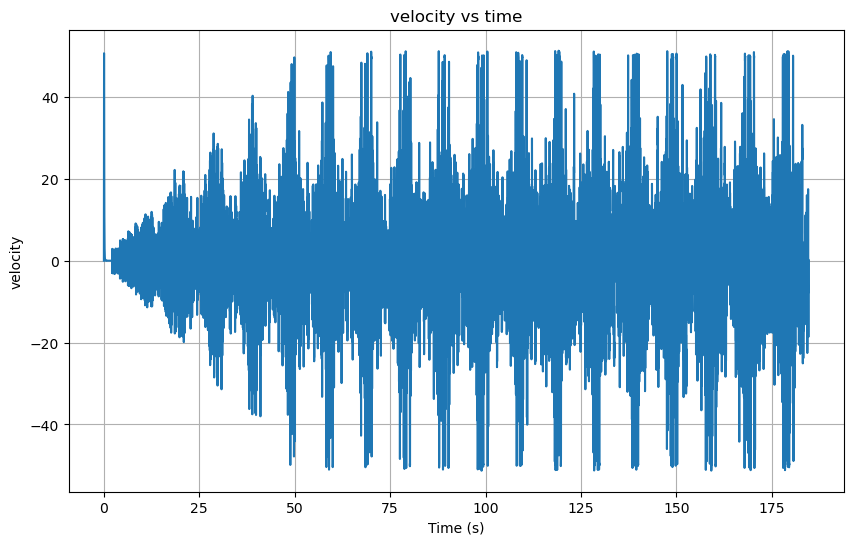

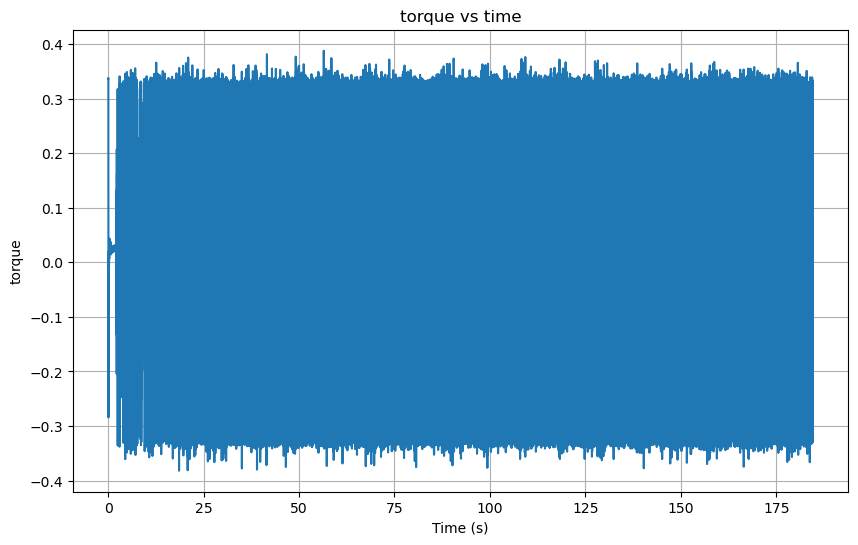

In [45]:
# perfom signal analysis to make sure there is not outliers
signals = ["target_position","position", "velocity", "torque"]

for signal in signals:
    data = dataset_100.get_df()[signal]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"\n{signal.capitalize()} Analysis:")
    print(f"Range: [{data.min():.3f}, {data.max():.3f}]")
    print(f"Mean ± Std: {data.mean():.3f} ± {data.std():.3f}")
    print(f"Outliers: {len(outliers)} ({(len(outliers)/len(data))*100:.2f}%)")
    print(f"Outlier range: [{lower_bound:.3f}, {upper_bound:.3f}]")
for signal in signals:
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_100.get_df()["time"], dataset_100.get_df()[signal])
    plt.title(f"{signal} vs time")
    plt.xlabel("Time (s)")
    plt.ylabel(signal)
    plt.grid(True)
    plt.show()


Target_position Analysis:
Range: [-8.898, 8.900]
Mean ± Std: 0.028 ± 3.629
Outliers: 0 (0.00%)
Outlier range: [-9.049, 9.127]

Position Analysis:
Range: [-6.787, 7.146]
Mean ± Std: 0.009 ± 1.039
Outliers: 10159 (11.01%)
Outlier range: [-1.336, 1.253]

Velocity Analysis:
Range: [-51.339, 51.307]
Mean ± Std: 0.021 ± 15.466
Outliers: 6352 (6.88%)
Outlier range: [-30.020, 29.915]

Torque Analysis:
Range: [-0.395, 0.394]
Mean ± Std: 0.002 ± 0.275
Outliers: 0 (0.00%)
Outlier range: [-1.283, 1.283]


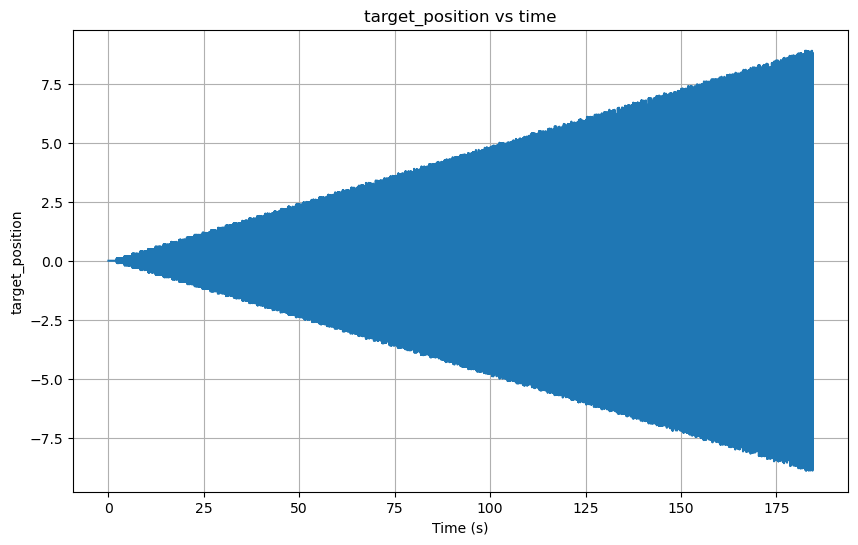

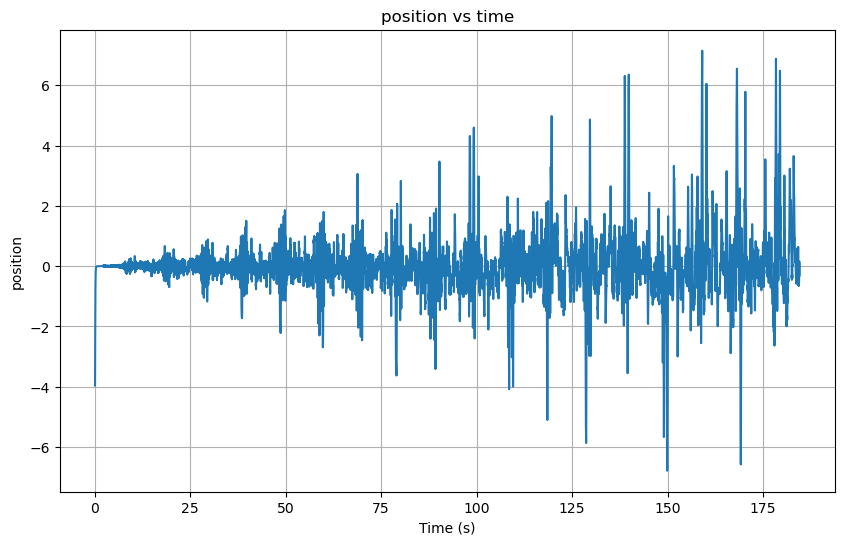

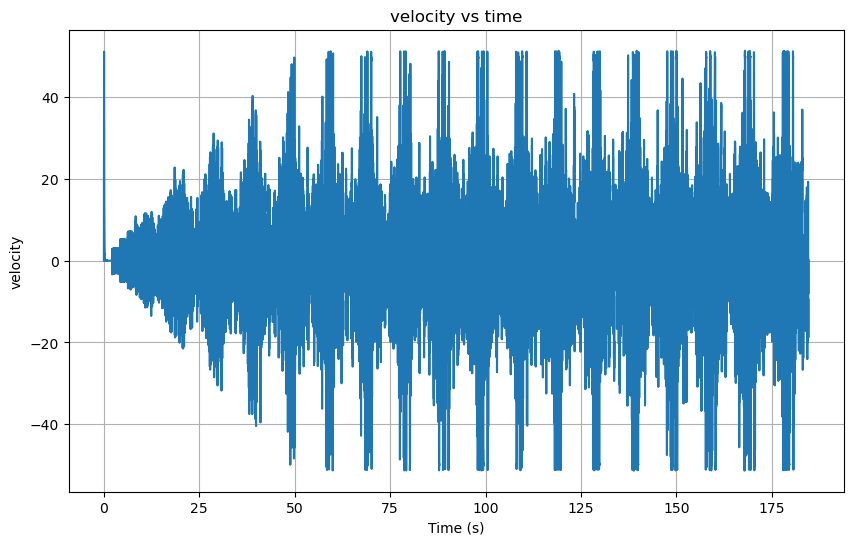

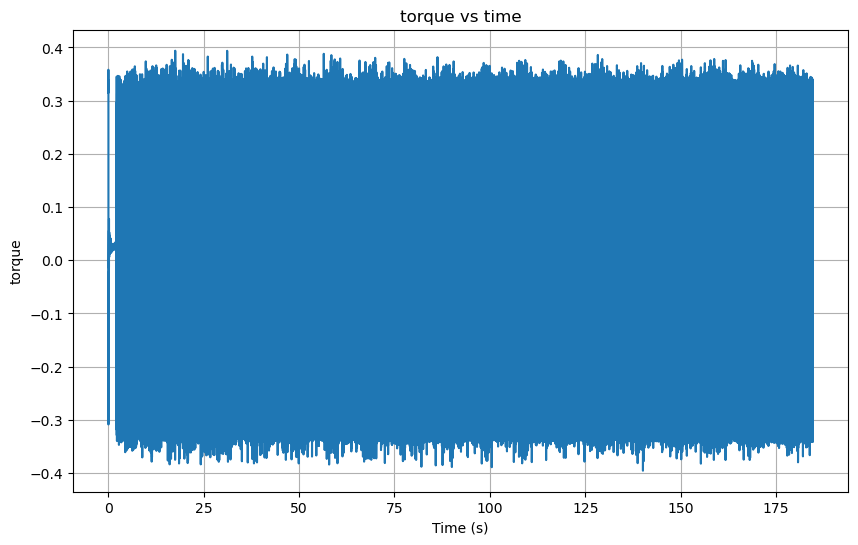

In [44]:
# perfom signal analysis to make sure there is not outliers
signals = ["target_position","position", "velocity", "torque"]

for signal in signals:
    data = dataset_500.get_df()[signal]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"\n{signal.capitalize()} Analysis:")
    print(f"Range: [{data.min():.3f}, {data.max():.3f}]")
    print(f"Mean ± Std: {data.mean():.3f} ± {data.std():.3f}")
    print(f"Outliers: {len(outliers)} ({(len(outliers)/len(data))*100:.2f}%)")
    print(f"Outlier range: [{lower_bound:.3f}, {upper_bound:.3f}]")
for signal in signals:
    plt.figure(figsize=(10, 6))
    plt.plot(dataset_500.get_df()["time"], dataset_500.get_df()[signal])
    plt.title(f"{signal} vs time")
    plt.xlabel("Time (s)")
    plt.ylabel(signal)
    plt.grid(True)
    plt.show()

In [53]:
features_100, targets_100, time_100 = dataset_100.preprocess_data()
features_500, targets_500, time_500 = dataset_500.preprocess_data()

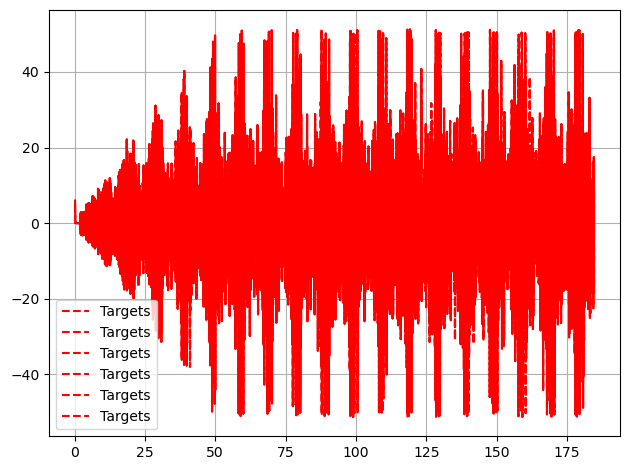

In [55]:
# Position plot
plt.plot(time_100,features_100, 'r--', label='Targets')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

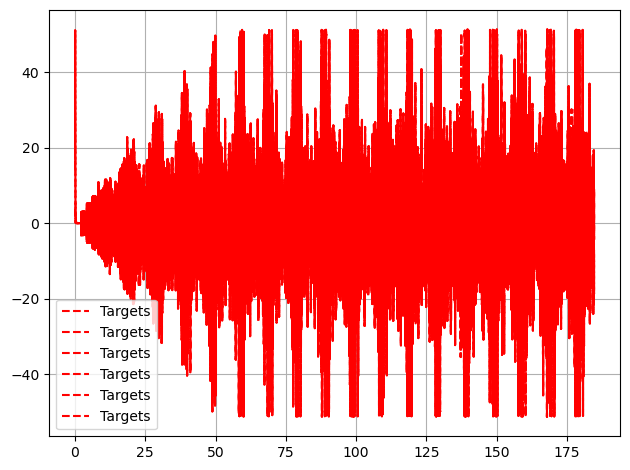

In [56]:
plt.plot(time_500,features_500, 'r--', label='Targets')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()